In [1]:
import pandas as pd                                    
import numpy as np                                     
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error         
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans


class CFG:
  data_folder ="../data/"

def reading_data(path: str) -> pd.DataFrame:
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  return train,test

train,test = reading_data(CFG.data_folder)
#pd.options.display.max_columns = 200
test_id = test['id']
train_id = train['id']
seed = 7 
seed2 = 77
tiney_fraction = 1e-05


misslead = [2, 12, 29, 31, 38, 77, 81, 97, 102, 115, 116, 130, 131, 133, 136, 143,
            146, 150, 153, 171, 180, 220, 221, 225, 231, 233, 244, 249, 270, 271, 274,
            283, 303, 343, 355, 396, 409, 417, 424, 435, 467, 470, 492, 495, 496, 515, 
            545, 551, 560, 579, 585, 586, 589, 592, 598, 611, 617, 636, 654, 656, 664, 683,
            688, 718, 721, 726, 754, 784, 788, 806, 812, 842, 855, 857, 862, 894, 900, 904,
            924, 947, 960, 980, 994, 1011, 1012, 1017, 1020, 1023, 1024, 1025, 1034, 1040, 
            1045, 1057, 1061, 1081, 1086, 1121, 1122, 1138, 1151, 1156, 1178, 1207, 1211, 1224, 
            1240, 1243, 1246, 1255, 1262, 1267, 1286, 1302, 1315, 1334, 1336, 1358, 1366, 1367,
            1392, 1405, 1427, 1461, 1465, 1474, 1504, 1513, 1517, 1521, 1522, 1530, 1534, 1585, 
            1587, 1604, 1608, 1614, 1615, 1619, 1625, 1646, 1649, 1652, 1656, 1657, 1665, 1674,
            1677, 1708, 1736, 1740, 1795, 1800, 1803, 1807, 1810, 1831, 1845, 1851, 1861, 1869,
            1876, 1877, 1886, 1893, 1898, 1900, 1930, 1953, 1954, 1967, 1994, 1999, 2020, 
            2029, 2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122]


<Axes: >

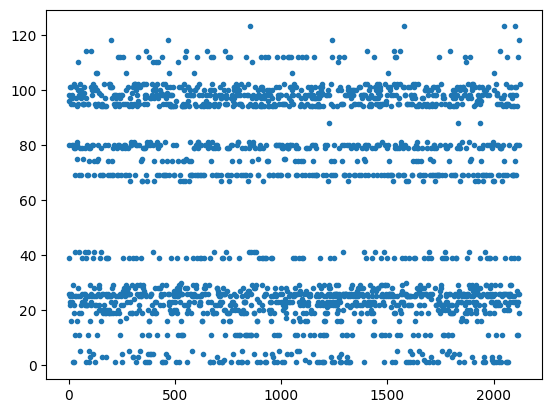

In [4]:
train.Target.plot(style='.')

In [23]:
train.columns.tolist()

['id',
 'REFLEC1',
 'REFLEC2',
 'REFLEC3',
 'REFLEC4',
 'REFLEC5',
 'REFLEC6',
 'REFLEC7',
 'PCA1',
 'PCA2',
 'PCA3',
 'NDVI1',
 'NDVI2',
 'NDVI3',
 'NDVI4',
 'ELEV1',
 'PEND1',
 'ILUM1',
 'TOPOIND1',
 'ROUGH1',
 'TRI1',
 'COFS1',
 'TMPMAN1',
 'TMPMAX1',
 'TMPMIN1',
 'TVARDAY1',
 'PRECIPAN1',
 'PRECIPWET1',
 'PRECIPDRY1',
 'PRECIPVAR1',
 'MARTONNE1',
 'LAT2',
 'LON1',
 'DOSEL1',
 'VVR1',
 'VHR1',
 'VHVVR1',
 'VVD1',
 'VHD1',
 'VHVVD1',
 'MNDWI1',
 'NDTI1',
 'Target']

In [27]:
train.describe()

,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,COFS1,TMPMAN1,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000
mean,254.458314,299.121997,563.690061,541.601978,2590.793688,1968.618464,1081.203486,15655.990204,601.307990,598.023249,0.461904,0.641356,0.806761,0.126093,890.175224,14.570774,164.541215,-0.074305,21.781441,6.664272,25.840791,21.467733,31.727713,9.303507,14.775220,1259.874667,323.343520,2.593903,118.647548,40.564694,20.835088,-104.911127,10.079604,0.199084,0.049876,0.256495,0.163228,0.044493,0.269030,-0.554340,0.312075,56.469147
std,135.965915,189.843372,248.496908,359.800824,574.675123,597.535634,502.598459,798.301229,463.536136,544.899128,0.200420,0.170308,0.148779,0.060387,610.571233,10.808916,40.832819,2.542731,16.992799,5.124741,4.962260,3.225144,2.932341,3.674324,1.749462,204.265854,46.063359,1.328069,7.134112,9.085739,0.386290,0.298098,7.675670,0.069079,0.013979,0.044096,0.069370,0.020398,0.054380,0.122184,0.091307,35.895589
min,41.000000,51.000000,129.000000,27.000000,69.000000,31.000000,19.000000,12963.531250,-1717.140381,-1072.501465,-0.587899,-0.269386,0.012909,0.017340,-2.000000,0.000000,8.000000,-21.125000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.825873,20.130173,-105.685837,0.000000,0.006709,0.001638,0.040542,0.008423,0.001854,0.041609,-0.707670,0.044444,1.000000
25%,165.000000,185.000000,418.000000,303.500000,2263.000000,1553.000000,700.000000,15150.290525,373.564545,209.359756,0.332800,0.556226,0.792451,0.073648,337.500000,5.235603,139.500000,-1.250000,8.000000,2.375000,22.000000,19.363567,30.589223,6.516582,13.531378,1102.252747,290.314468,1.999389,116.656315,34.587288,20.521977,-105.143547,4.000000,0.166548,0.042742,0.235315,0.119105,0.030542,0.241296,-0.609535,0.251258,23.000000
50%,229.000000,249.000000,502.000000,431.000000,2589.000000,1896.000000,948.000000,15550.262700,639.532715,600.063965,0.445161,0.672762,0.856841,0.125041,906.000000,12.425244,175.000000,-0.125000,18.000000,5.625000,25.000000,21.851374,32.207619,9.061740,14.802163,1247.262817,320.142731,2.000019,119.834328,39.689144,20.866995,-104.928162,10.000000,0.198767,0.050159,0.258121,0.164936,0.044264,0.273498,-0.582924,0.331533,69.000000
75%,310.500000,359.000000,643.000000,674.000000,2959.500000,2317.000000,1363.000000,16030.361330,895.429840,975.081451,0.610333,0.763075,0.891188,0.177835,1342.500000,22.440016,190.000000,1.125000,33.000000,9.875000,29.000000,24.180056,33.413620,12.676065,16.183157,1398.298462,348.216248,3.353902,121.928608,44.267740,21.143646,-104.637318,15.000000,0.226662,0.057785,0.280992,0.200105,0.058120,0.303065,-0.544857,0.384907,95.000000
max,1187.000000,1938.000000,2970.000000,3732.000000,5170.000000,5613.000000,3609.000000,21658.392580,2169.373535,2500.275635,0.865767,0.905789,0.965859,0.413901,2522.000000,55.593933,255.000000,23.250000,131.000000,38.625000,57.000000,26.376032,37.879982,15.432009,18.546682,1897.408081,465.404449,7.677537,128.852280,72.145851,21.487593,-104.413536,31.000000,1.033453,0.238137,0.582059,0.918610,0.191149,0.724450,0.684754,0.470513,123.000000


In [25]:
pd.options.display.max_columns=50
train

,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,COFS1,TMPMAN1,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
0,id_0taivml7ol,231.0,251.0,496.0,464.0,2557.0,2035.0,1051.0,15578.91895,672.583374,565.505066,0.562368,0.681453,0.763305,0.067587,2014.0,28.844036,199.0,1.875,42.0,12.375,33.0,15.675409,25.320597,4.350704,13.876810,1623.614990,390.804352,2.999952,116.944008,63.238083,20.284925,-104.869507,17.0,0.174004,0.038816,0.222946,0.145658,0.036469,0.250200,-0.608060,0.318859,80
1,id_croxu0xdq9,345.0,402.0,805.0,805.0,2997.0,2443.0,1434.0,16403.79688,900.683044,516.083557,0.253720,0.546519,0.869048,0.253607,656.0,16.630325,185.0,-2.000,24.0,7.750,19.0,23.944405,35.669025,10.929708,16.047564,949.864319,257.712494,2.000000,117.124428,27.983301,20.937754,-104.551094,6.0,0.239050,0.055795,0.233304,0.130232,0.035914,0.275557,-0.504310,0.260253,39
2,id_qfv0klgl9b,413.0,518.0,775.0,1022.0,2936.0,3266.0,2351.0,17203.26953,1275.056519,-325.276093,0.251043,0.479669,0.908817,0.235585,1543.0,3.821051,181.0,0.375,4.0,1.875,22.0,17.999048,31.231258,3.986085,17.208784,1030.634766,238.203903,5.000000,104.941284,36.809792,20.285265,-104.509377,0.0,0.114193,0.028076,0.245645,0.041095,0.007986,0.193860,-0.616432,0.162898,26
3,id_mlubcnl27r,196.0,295.0,806.0,675.0,2964.0,2249.0,1260.0,16105.81738,900.010620,637.292908,0.178295,0.539449,0.860523,0.257632,82.0,1.312327,183.0,0.625,1.0,0.625,21.0,25.381269,33.802109,14.417583,12.934464,1475.699097,367.842773,2.000000,121.767151,41.708473,20.930613,-105.037415,0.0,0.177530,0.057263,0.322373,0.069336,0.008118,0.116911,-0.472340,0.281847,96
4,id_rej7e1nz2p,366.0,404.0,697.0,803.0,2479.0,2722.0,1794.0,16414.72266,822.154480,-137.591675,0.302760,0.490486,0.728987,0.148521,1906.0,5.921676,193.0,-1.875,5.0,1.875,33.0,16.311563,28.353050,3.717713,15.805076,1248.408325,289.702484,4.976198,107.161186,47.448189,20.153313,-104.504051,0.0,0.153453,0.035333,0.230104,0.104264,0.022265,0.213336,-0.592278,0.205492,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,id_omwzgv71mm,293.0,332.0,602.0,648.0,2420.0,2524.0,1515.0,16059.07520,773.241455,40.498398,0.368202,0.601072,0.868863,0.198601,1420.0,42.870125,191.0,4.000,68.0,22.625,29.0,20.074528,31.955158,7.285109,16.135509,1096.249756,287.278351,2.978217,115.863518,36.453400,20.974068,-104.491508,8.0,0.254344,0.058652,0.230509,0.270934,0.075479,0.278487,-0.614843,0.249814,26
2119,id_4qbcbd1fp3,131.0,133.0,306.0,220.0,2408.0,1258.0,525.0,14762.36426,336.915527,1024.408936,0.762701,0.828017,0.871870,0.032431,1267.0,15.497478,170.0,-0.875,22.0,7.750,32.0,19.191128,29.223577,7.365193,14.627878,1346.174927,332.470703,3.999952,116.026375,46.117218,20.729744,-104.929894,25.0,0.200217,0.049809,0.248651,0.164714,0.048038,0.291467,-0.608696,0.411105,80
2120,id_hnsxwu0ry2,281.0,366.0,677.0,672.0,972.0,291.0,209.0,14102.01270,-1279.346680,542.513550,-0.254423,0.076933,0.325238,0.199032,8.0,2.074427,184.0,0.500,3.0,0.750,23.0,25.517536,33.300285,15.237956,11.505482,1478.930542,402.560181,1.000000,128.455093,41.639446,21.336721,-105.234650,0.0,0.009476,0.003510,0.366512,0.118911,0.010397,0.087359,0.398760,0.164000,19
2121,id_wbidurxelw,296.0,253.0,483.0,389.0,2181.0,1879.0,1022.0,15343.14941,379.010010,404.744293,0.440991,0.675917,0.890033,0.183788,1273.0,36.999649,195.0,-0.125,55.0,16.750,25.0,19.214296,30.951569,6.446369,15.682813,1116.901978,278.936493,4.045544,111.452614,38.238060,20.708647,-104.551392,10.0,0.271714,0.065200,0.239870,0.276998,0.074064,0.267286,-0.591024,0.295415,118


In [2]:
train.shape

(2123, 43)

In [3]:
train.shape
pd.options.display.max_columns = 40

In [4]:
train.head()

,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,...,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
0,id_0taivml7ol,231.0,251.0,496.0,464.0,2557.0,2035.0,1051.0,15578.91895,672.583374,565.505066,0.562368,0.681453,0.763305,0.067587,2014.0,28.844036,199.0,1.875,42.0,...,25.320597,4.350704,13.876810,1623.614990,390.804352,2.999952,116.944008,63.238083,20.284925,-104.869507,17.0,0.174004,0.038816,0.222946,0.145658,0.036469,0.250200,-0.608060,0.318859,80
1,id_croxu0xdq9,345.0,402.0,805.0,805.0,2997.0,2443.0,1434.0,16403.79688,900.683044,516.083557,0.253720,0.546519,0.869048,0.253607,656.0,16.630325,185.0,-2.000,24.0,...,35.669025,10.929708,16.047564,949.864319,257.712494,2.000000,117.124428,27.983301,20.937754,-104.551094,6.0,0.239050,0.055795,0.233304,0.130232,0.035914,0.275557,-0.504310,0.260253,39
2,id_qfv0klgl9b,413.0,518.0,775.0,1022.0,2936.0,3266.0,2351.0,17203.26953,1275.056519,-325.276093,0.251043,0.479669,0.908817,0.235585,1543.0,3.821051,181.0,0.375,4.0,...,31.231258,3.986085,17.208784,1030.634766,238.203903,5.000000,104.941284,36.809792,20.285265,-104.509377,0.0,0.114193,0.028076,0.245645,0.041095,0.007986,0.193860,-0.616432,0.162898,26
3,id_mlubcnl27r,196.0,295.0,806.0,675.0,2964.0,2249.0,1260.0,16105.81738,900.010620,637.292908,0.178295,0.539449,0.860523,0.257632,82.0,1.312327,183.0,0.625,1.0,...,33.802109,14.417583,12.934464,1475.699097,367.842773,2.000000,121.767151,41.708473,20.930613,-105.037415,0.0,0.177530,0.057263,0.322373,0.069336,0.008118,0.116911,-0.472340,0.281847,96
4,id_rej7e1nz2p,366.0,404.0,697.0,803.0,2479.0,2722.0,1794.0,16414.72266,822.154480,-137.591675,0.302760,0.490486,0.728987,0.148521,1906.0,5.921676,193.0,-1.875,5.0,...,28.353050,3.717713,15.805076,1248.408325,289.702484,4.976198,107.161186,47.448189,20.153313,-104.504051,0.0,0.153453,0.035333,0.230104,0.104264,0.022265,0.213336,-0.592278,0.205492,98


In [ ]:
train.iloc[misslead]['Target'].value_counts(ascending=False)

In [ ]:
train['Target'].value_counts(ascending=False)

In [18]:
train.columns.tolist()

['id',
 'REFLEC1',
 'REFLEC2',
 'REFLEC3',
 'REFLEC4',
 'REFLEC5',
 'REFLEC6',
 'REFLEC7',
 'PCA1',
 'PCA2',
 'PCA3',
 'NDVI1',
 'NDVI2',
 'NDVI3',
 'NDVI4',
 'ELEV1',
 'PEND1',
 'ILUM1',
 'TOPOIND1',
 'ROUGH1',
 'TRI1',
 'COFS1',
 'TMPMAN1',
 'TMPMAX1',
 'TMPMIN1',
 'TVARDAY1',
 'PRECIPAN1',
 'PRECIPWET1',
 'PRECIPDRY1',
 'PRECIPVAR1',
 'MARTONNE1',
 'LAT2',
 'LON1',
 'DOSEL1',
 'VVR1',
 'VHR1',
 'VHVVR1',
 'VVD1',
 'VHD1',
 'VHVVD1',
 'MNDWI1',
 'NDTI1',
 'Target']

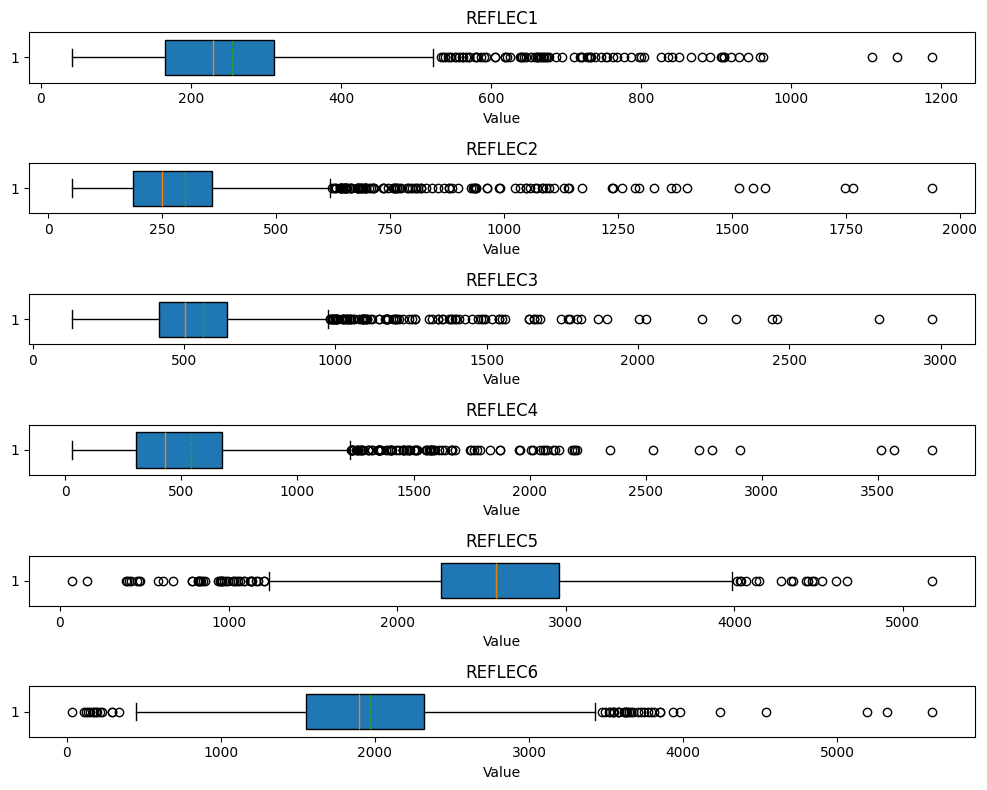

In [5]:
features = train.columns.tolist()[1:7]

features = features
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 8), sharex=False)

# Iterate over features and create box plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.boxplot(train[feature].dropna(), vert=False, widths=0.7, patch_artist=True, meanline=True, showmeans=True, showcaps=True)
    ax.set_title(feature)
    ax.set_xlabel('Value')

plt.tight_layout()
plt.show()

['REFLEC1',
 'REFLEC2',
 'REFLEC3',
 'REFLEC4',
 'REFLEC5',
 'REFLEC6',
 'REFLEC7',
 'PCA1']

<Figure size 1400x600 with 0 Axes>

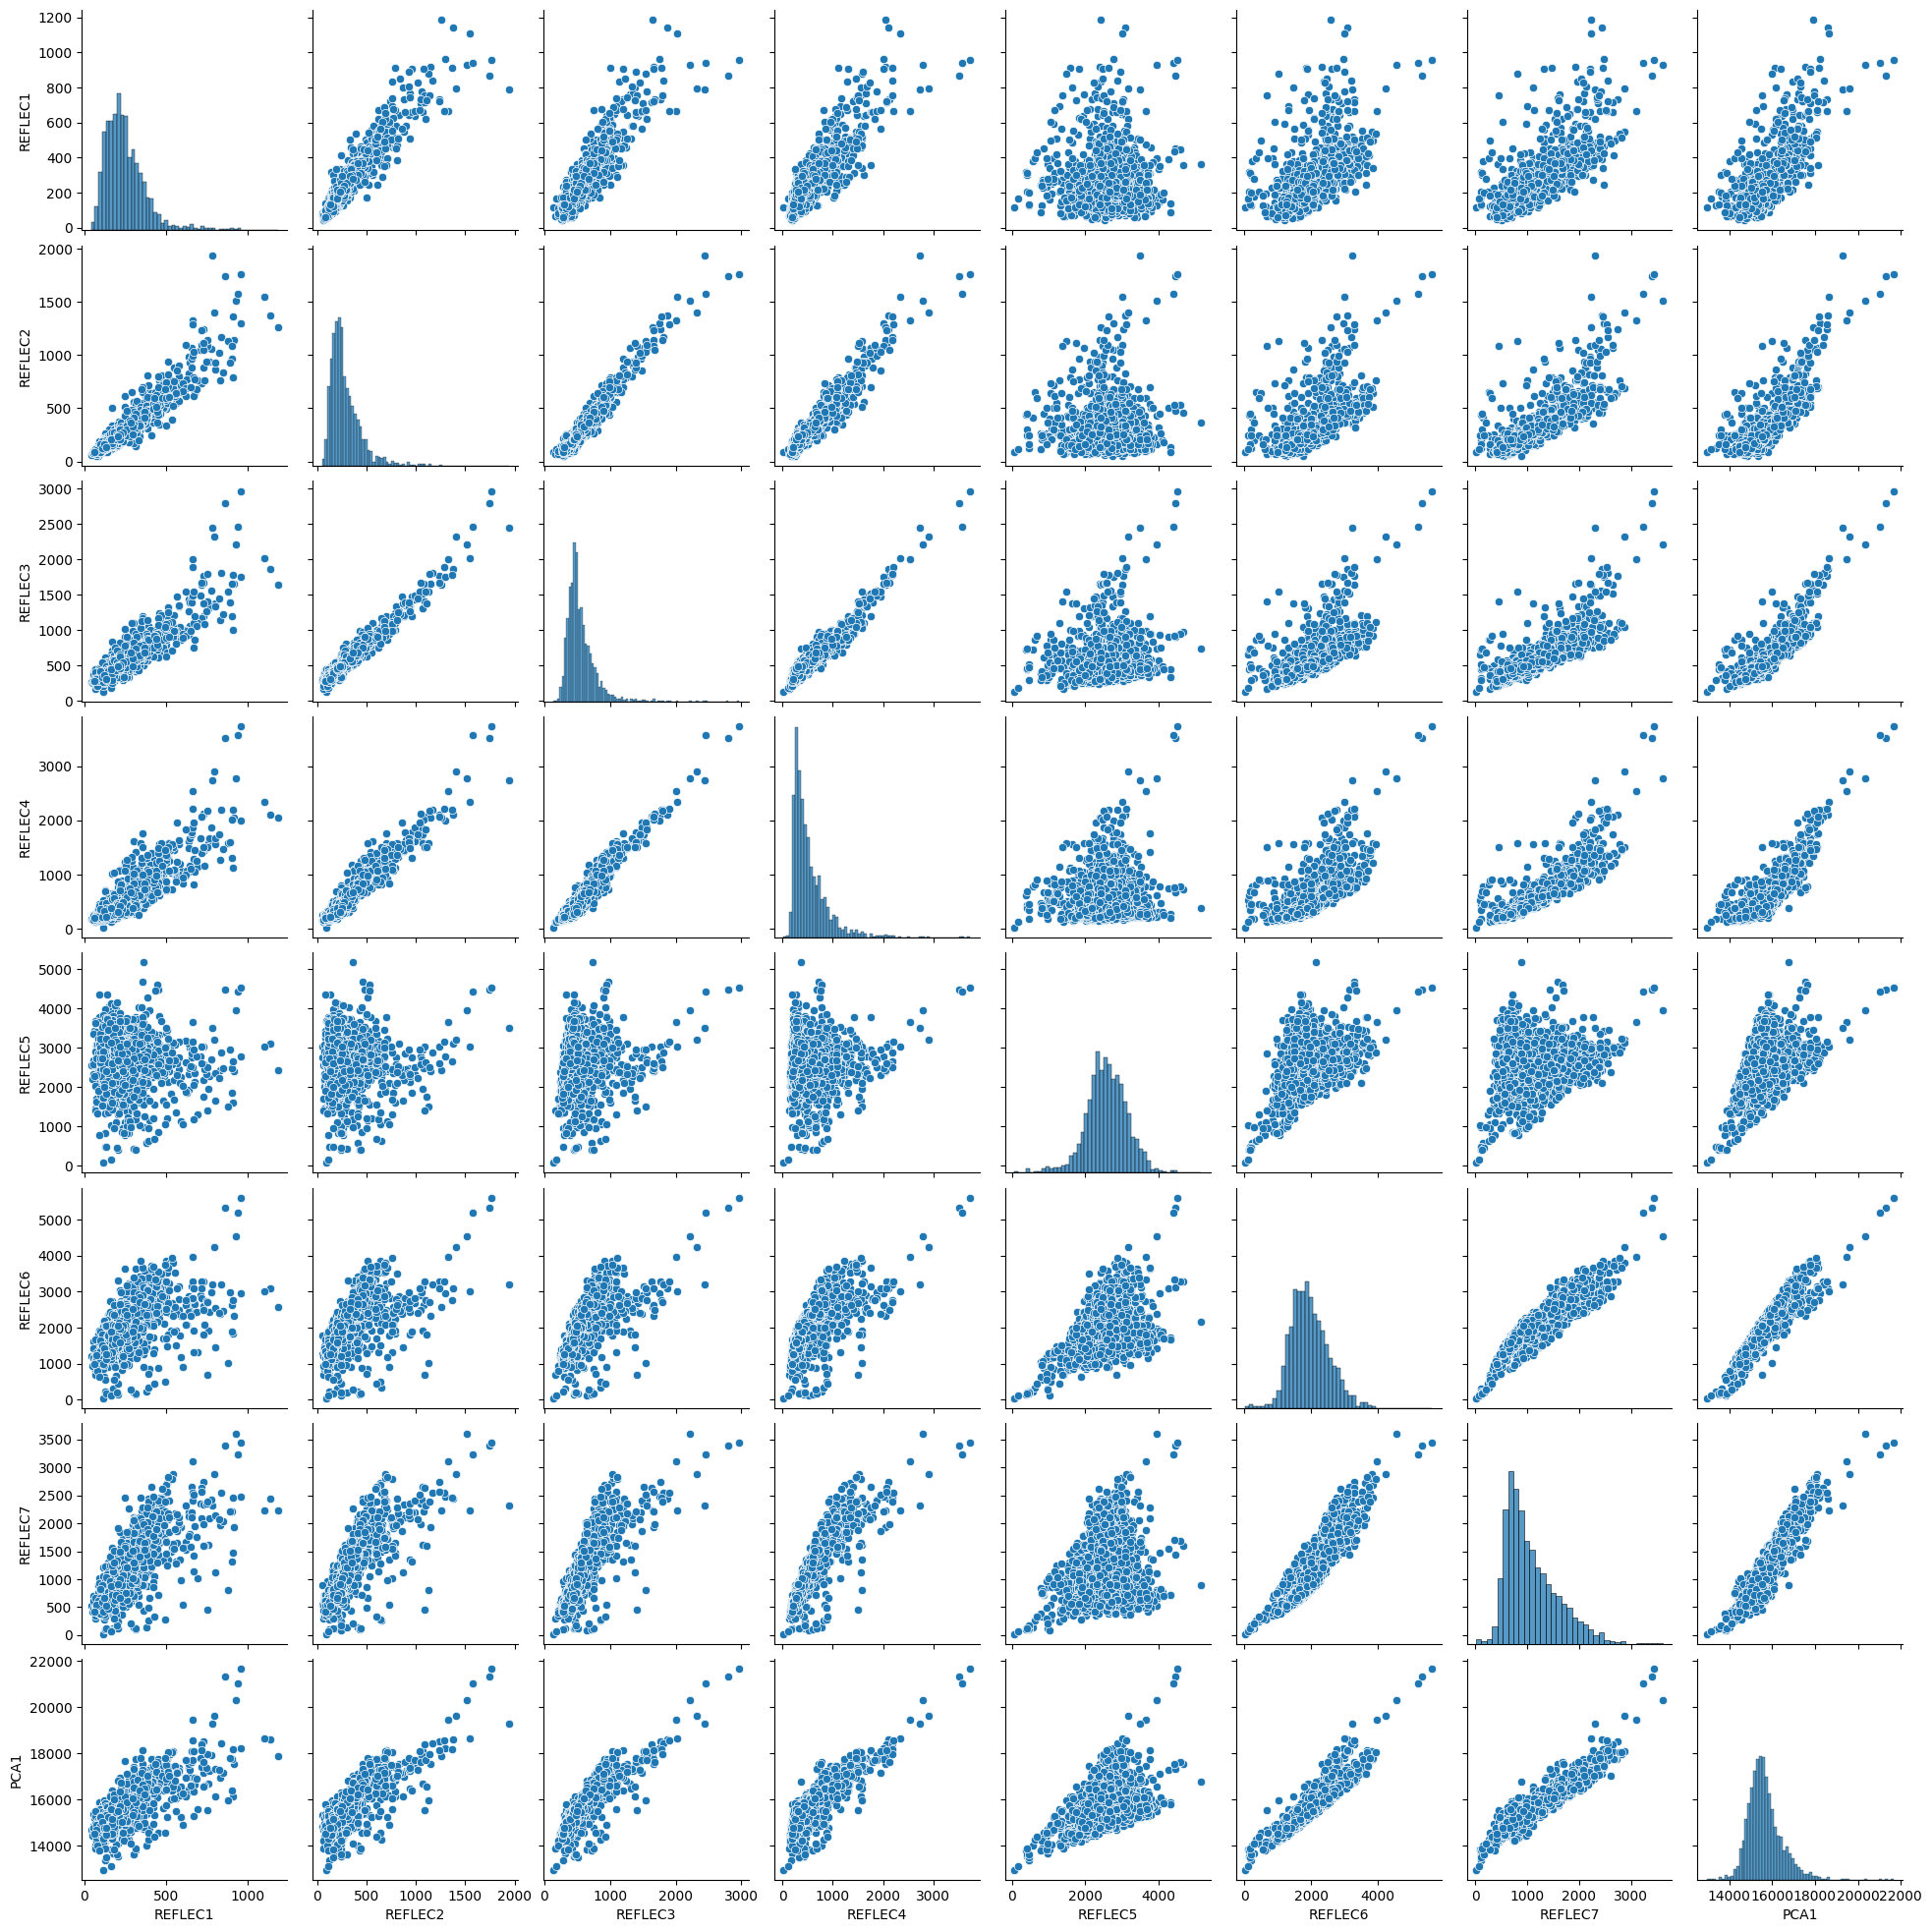

In [10]:
num_feats = train[train.columns.tolist()[1:9]]

plt.figure(figsize=(14,6))
sns.pairplot(num_feats)
plt.show()

<Figure size 1400x600 with 0 Axes>

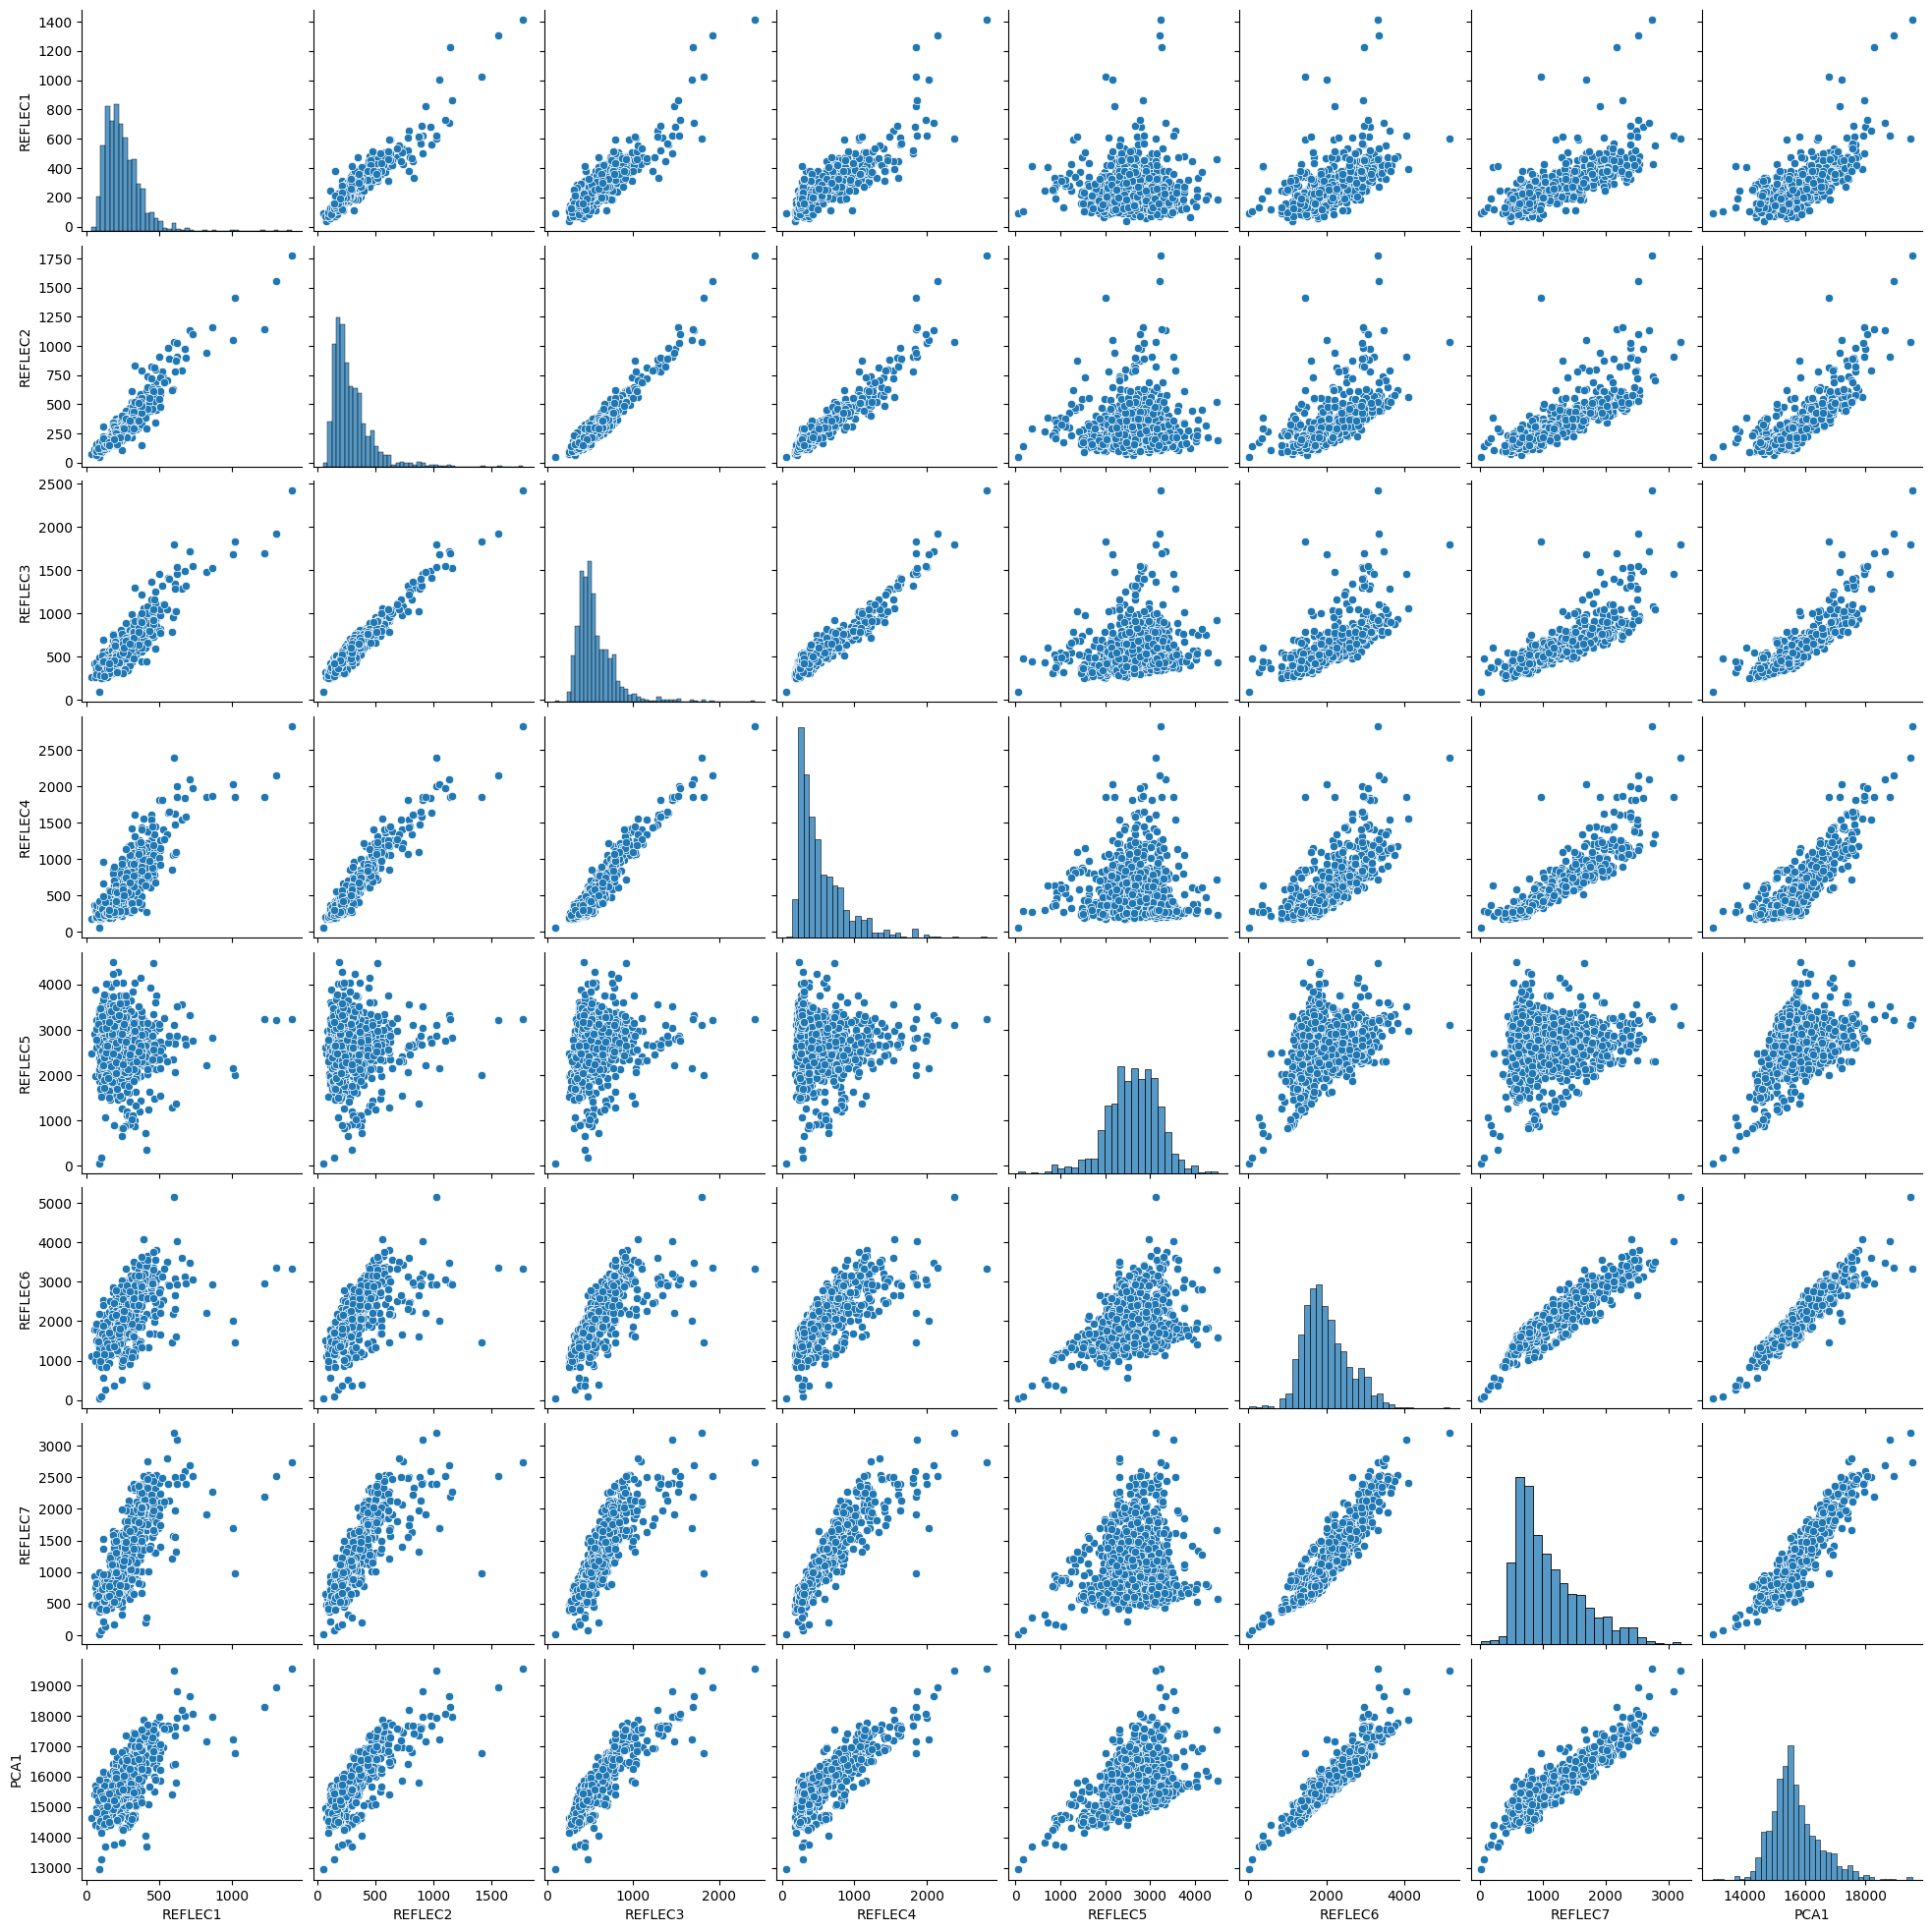

In [11]:
num_feats = test[train.columns.tolist()[1:9]]

plt.figure(figsize=(14,6))
sns.pairplot(num_feats)
plt.show()

In [12]:
train

,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,...,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
0,id_0taivml7ol,231.0,251.0,496.0,464.0,2557.0,2035.0,1051.0,15578.91895,672.583374,565.505066,0.562368,0.681453,0.763305,0.067587,2014.0,28.844036,199.0,1.875,42.0,...,25.320597,4.350704,13.876810,1623.614990,390.804352,2.999952,116.944008,63.238083,20.284925,-104.869507,17.0,0.174004,0.038816,0.222946,0.145658,0.036469,0.250200,-0.608060,0.318859,80
1,id_croxu0xdq9,345.0,402.0,805.0,805.0,2997.0,2443.0,1434.0,16403.79688,900.683044,516.083557,0.253720,0.546519,0.869048,0.253607,656.0,16.630325,185.0,-2.000,24.0,...,35.669025,10.929708,16.047564,949.864319,257.712494,2.000000,117.124428,27.983301,20.937754,-104.551094,6.0,0.239050,0.055795,0.233304,0.130232,0.035914,0.275557,-0.504310,0.260253,39
2,id_qfv0klgl9b,413.0,518.0,775.0,1022.0,2936.0,3266.0,2351.0,17203.26953,1275.056519,-325.276093,0.251043,0.479669,0.908817,0.235585,1543.0,3.821051,181.0,0.375,4.0,...,31.231258,3.986085,17.208784,1030.634766,238.203903,5.000000,104.941284,36.809792,20.285265,-104.509377,0.0,0.114193,0.028076,0.245645,0.041095,0.007986,0.193860,-0.616432,0.162898,26
3,id_mlubcnl27r,196.0,295.0,806.0,675.0,2964.0,2249.0,1260.0,16105.81738,900.010620,637.292908,0.178295,0.539449,0.860523,0.257632,82.0,1.312327,183.0,0.625,1.0,...,33.802109,14.417583,12.934464,1475.699097,367.842773,2.000000,121.767151,41.708473,20.930613,-105.037415,0.0,0.177530,0.057263,0.322373,0.069336,0.008118,0.116911,-0.472340,0.281847,96
4,id_rej7e1nz2p,366.0,404.0,697.0,803.0,2479.0,2722.0,1794.0,16414.72266,822.154480,-137.591675,0.302760,0.490486,0.728987,0.148521,1906.0,5.921676,193.0,-1.875,5.0,...,28.353050,3.717713,15.805076,1248.408325,289.702484,4.976198,107.161186,47.448189,20.153313,-104.504051,0.0,0.153453,0.035333,0.230104,0.104264,0.022265,0.213336,-0.592278,0.205492,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,id_omwzgv71mm,293.0,332.0,602.0,648.0,2420.0,2524.0,1515.0,16059.07520,773.241455,40.498398,0.368202,0.601072,0.868863,0.198601,1420.0,42.870125,191.0,4.000,68.0,...,31.955158,7.285109,16.135509,1096.249756,287.278351,2.978217,115.863518,36.453400,20.974068,-104.491508,8.0,0.254344,0.058652,0.230509,0.270934,0.075479,0.278487,-0.614843,0.249814,26
2119,id_4qbcbd1fp3,131.0,133.0,306.0,220.0,2408.0,1258.0,525.0,14762.36426,336.915527,1024.408936,0.762701,0.828017,0.871870,0.032431,1267.0,15.497478,170.0,-0.875,22.0,...,29.223577,7.365193,14.627878,1346.174927,332.470703,3.999952,116.026375,46.117218,20.729744,-104.929894,25.0,0.200217,0.049809,0.248651,0.164714,0.048038,0.291467,-0.608696,0.411105,80
2120,id_hnsxwu0ry2,281.0,366.0,677.0,672.0,972.0,291.0,209.0,14102.01270,-1279.346680,542.513550,-0.254423,0.076933,0.325238,0.199032,8.0,2.074427,184.0,0.500,3.0,...,33.300285,15.237956,11.505482,1478.930542,402.560181,1.000000,128.455093,41.639446,21.336721,-105.234650,0.0,0.009476,0.003510,0.366512,0.118911,0.010397,0.087359,0.398760,0.164000,19
2121,id_wbidurxelw,296.0,253.0,483.0,389.0,2181.0,1879.0,1022.0,15343.14941,379.010010,404.744293,0.440991,0.675917,0.890033,0.183788,1273.0,36.999649,195.0,-0.125,55.0,...,30.951569,6.446369,15.682813,1116.901978,278.936493,4.045544,111.452614,38.238060,20.708647,-104.551392,10.0,0.271714,0.065200,0.239870,0.276998,0.074064,0.267286,-0.591024,0.295415,118


In [15]:
train.describe()

,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,...,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,...,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000
mean,254.458314,299.121997,563.690061,541.601978,2590.793688,1968.618464,1081.203486,15655.990204,601.307990,598.023249,0.461904,0.641356,0.806761,0.126093,890.175224,14.570774,164.541215,-0.074305,21.781441,6.664272,...,31.727713,9.303507,14.775220,1259.874667,323.343520,2.593903,118.647548,40.564694,20.835088,-104.911127,10.079604,0.199084,0.049876,0.256495,0.163228,0.044493,0.269030,-0.554340,0.312075,56.469147
std,135.965915,189.843372,248.496908,359.800824,574.675123,597.535634,502.598459,798.301229,463.536136,544.899128,0.200420,0.170308,0.148779,0.060387,610.571233,10.808916,40.832819,2.542731,16.992799,5.124741,...,2.932341,3.674324,1.749462,204.265854,46.063359,1.328069,7.134112,9.085739,0.386290,0.298098,7.675670,0.069079,0.013979,0.044096,0.069370,0.020398,0.054380,0.122184,0.091307,35.895589
min,41.000000,51.000000,129.000000,27.000000,69.000000,31.000000,19.000000,12963.531250,-1717.140381,-1072.501465,-0.587899,-0.269386,0.012909,0.017340,-2.000000,0.000000,8.000000,-21.125000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.825873,20.130173,-105.685837,0.000000,0.006709,0.001638,0.040542,0.008423,0.001854,0.041609,-0.707670,0.044444,1.000000
25%,165.000000,185.000000,418.000000,303.500000,2263.000000,1553.000000,700.000000,15150.290525,373.564545,209.359756,0.332800,0.556226,0.792451,0.073648,337.500000,5.235603,139.500000,-1.250000,8.000000,2.375000,...,30.589223,6.516582,13.531378,1102.252747,290.314468,1.999389,116.656315,34.587288,20.521977,-105.143547,4.000000,0.166548,0.042742,0.235315,0.119105,0.030542,0.241296,-0.609535,0.251258,23.000000
50%,229.000000,249.000000,502.000000,431.000000,2589.000000,1896.000000,948.000000,15550.262700,639.532715,600.063965,0.445161,0.672762,0.856841,0.125041,906.000000,12.425244,175.000000,-0.125000,18.000000,5.625000,...,32.207619,9.061740,14.802163,1247.262817,320.142731,2.000019,119.834328,39.689144,20.866995,-104.928162,10.000000,0.198767,0.050159,0.258121,0.164936,0.044264,0.273498,-0.582924,0.331533,69.000000
75%,310.500000,359.000000,643.000000,674.000000,2959.500000,2317.000000,1363.000000,16030.361330,895.429840,975.081451,0.610333,0.763075,0.891188,0.177835,1342.500000,22.440016,190.000000,1.125000,33.000000,9.875000,...,33.413620,12.676065,16.183157,1398.298462,348.216248,3.353902,121.928608,44.267740,21.143646,-104.637318,15.000000,0.226662,0.057785,0.280992,0.200105,0.058120,0.303065,-0.544857,0.384907,95.000000
max,1187.000000,1938.000000,2970.000000,3732.000000,5170.000000,5613.000000,3609.000000,21658.392580,2169.373535,2500.275635,0.865767,0.905789,0.965859,0.413901,2522.000000,55.593933,255.000000,23.250000,131.000000,38.625000,...,37.879982,15.432009,18.546682,1897.408081,465.404449,7.677537,128.852280,72.145851,21.487593,-104.413536,31.000000,1.033453,0.238137,0.582059,0.918610,0.191149,0.724450,0.684754,0.470513,123.000000


In [16]:
test.describe()

,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,...,TMPMAN1,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,252.652928,299.697397,566.720174,546.188720,2621.140998,1990.054230,1098.781996,15686.180518,629.161316,601.034452,0.463711,0.641685,0.808430,0.125692,864.381779,14.619164,165.093275,-0.023861,21.945770,6.657538,...,21.556996,31.723780,9.449174,14.700473,1266.529485,324.233233,2.615676,118.667023,40.698183,20.836355,-104.921710,9.755965,0.199919,0.049468,0.254410,0.163367,0.044263,0.267165,-0.556188,0.311519
std,133.883873,180.389248,235.596169,349.820207,589.140733,608.294429,522.909630,804.006200,467.043622,568.773431,0.197562,0.168508,0.143053,0.061030,615.609146,10.886450,40.594416,2.248719,16.926978,5.053446,...,3.271690,2.966823,3.704967,1.766987,206.541803,46.479713,1.325594,7.304224,9.172049,0.374665,0.288113,7.524559,0.064334,0.012250,0.045110,0.063005,0.019442,0.052116,0.103963,0.094287
min,39.000000,53.000000,90.000000,61.000000,58.000000,35.000000,18.000000,12936.594730,-1533.461426,-1443.811157,-0.890304,-0.227333,0.097070,0.018484,0.000000,0.000000,0.000000,-12.375000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.494891,20.128483,-105.661644,0.000000,0.011333,0.002036,0.058094,0.012269,0.001661,0.075491,-0.697608,0.030221
25%,162.000000,182.000000,418.000000,298.000000,2279.250000,1574.500000,697.000000,15195.002688,381.710800,186.677433,0.321608,0.552504,0.792674,0.074383,288.000000,4.721770,142.000000,-1.250000,7.000000,2.250000,...,19.556197,30.721707,6.652017,13.451155,1105.662109,292.938454,2.000000,116.780954,34.589861,20.517754,-105.147911,3.250000,0.167859,0.042094,0.231988,0.122024,0.030610,0.239558,-0.606651,0.246768
50%,227.000000,249.500000,505.000000,432.000000,2657.000000,1892.000000,944.500000,15559.883785,676.074097,606.578766,0.447558,0.671157,0.860696,0.121748,856.500000,12.682543,175.000000,0.000000,18.000000,5.625000,...,22.117612,32.175087,9.378389,14.690455,1258.440369,322.142059,2.000037,119.851112,39.907684,20.876576,-104.942417,9.000000,0.199585,0.050264,0.256445,0.165235,0.043753,0.274319,-0.579587,0.328835
75%,313.000000,361.750000,651.750000,683.500000,3022.500000,2338.000000,1386.750000,16077.348878,914.212097,1034.892792,0.620281,0.770195,0.892683,0.174982,1302.000000,22.793642,189.000000,1.000000,33.000000,10.000000,...,24.290761,33.367149,12.941702,16.157982,1412.912231,349.541428,3.429280,121.975443,44.220059,21.125696,-104.678022,15.000000,0.227523,0.057672,0.281678,0.201657,0.057363,0.301726,-0.545381,0.388189
max,1412.000000,1778.000000,2417.000000,2821.000000,4501.000000,5145.000000,3201.000000,19562.039060,2030.774658,2356.245361,0.834036,0.881114,0.944320,0.475185,2379.000000,49.533905,250.000000,10.750000,94.000000,27.250000,...,26.525576,37.910549,15.385217,18.577991,1916.495117,472.053955,7.515440,129.100632,72.210121,21.487144,-104.409470,29.000000,0.874388,0.097153,0.421723,0.482210,0.140688,0.455735,0.674336,0.479317


In [72]:
train_id = train['id']
test_id = test['id']
for df in(train,test):
    df.drop(columns=['id'], axis=1,inplace=True)


In [73]:
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
n_splits = 5 
gkf = StratifiedGroupKFold(n_splits=n_splits)
model = LGBMClassifier(random_state=seed)

def validate(trainset,testset,target_col):
    model.fit(trainset.drop(columns=[target_col]),trainset[target_col])
    y_predicted = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_predicted[valid_idx]
    print(f"std : {valid_testset}")
    score = f1_score(valid_pred,valid_testset,average="micro")
    print(f"score : {score}")
    
    return score

stds = []
f1_scores = []
    
for train_index,test_index in gkf.split(train.drop(columns='Target'), train['Target'],train_id):
    for i in range(1):
        print(f"train shape : {train_index.shape}, test shape:{test_index.shape}")
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    stds.append(test_v['Target'].std())
    f1_scores.append(validate(trainset=train_v,testset=test_v,target_col='Target'))

print('f1_score:', f1_score)

/Users/ahmed/Downloads/computerscience/AI-Compeitions/INEGI-GCIM/vegitiables/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


train shape : (1698,), test shape:(425,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9478
[LightGBM] [Info] Number of data points in the train set: 1698, number of used features: 41
[LightGBM] [Info] Start training from score -3.294072
[LightGBM] [Info] Start training from score -6.338594
[LightGBM] [Info] Start training from score -4.798149
[LightGBM] [Info] Start training from score -4.603993
[LightGBM] [Info] Start training from score -5.039311
[LightGBM] [Info] Start training from score -3.466914
[LightGBM] [Info] Start training from score -4.141370
[LightGBM] [Info] Start training from score -6.050912
[LightGBM] [Info] Start training from score -3.294072
[LightGBM] [Info] Start training from score -3.853687
[LightGBM] [Info] Start training from score -6.338594
[LightGBM] [Info] Start training from score -3.160540
[LightGBM] [Info] Start

In [74]:
value  = np.array(rmse).mean()
model.fit(train.drop(columns='Target'),train['Target'])
y_pred = model.predict_proba(test)
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  
#sub_df = pd.DataFrame({'id': test_id,'Target':y_pred})
sub_df.to_csv(f"../submissions/submission{value}.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9499
[LightGBM] [Info] Number of data points in the train set: 2123, number of used features: 41
[LightGBM] [Info] Start training from score -3.303877
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -4.770214
[LightGBM] [Info] Start training from score -4.569543
[LightGBM] [Info] Start training from score -5.021528
[LightGBM] [Info] Start training from score -3.470931
[LightGBM] [Info] Start training from score -4.134225
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -3.291138
[LightGBM] [Info] Start training from score -3.853923
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -3.171949
[LightGBM] [Info] Start training from score -3.217934
[LightGBM]

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_98003/3802090642.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_98003/3802090642.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_98003/3802090642.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini